In [1]:
from datetime import datetime
import os
import re

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

from ipynb.fs.defs.functions import prep_data, train, break_out_solution
from models.single_head_multi_class.model import SingleHeadMultiClass
from models.multi_head_model.model import MultiHeadModel
from models.testing.model import Model

# Setup rng
torch.manual_seed(42)
np.random.seed(42)

In [36]:
model_type = SingleHeadMultiClass

In [4]:
# Check cuda is available and if so, set DEVICE to use gpu device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [5]:
# Load images and labels
data = pd.read_csv("data/unzipped/training_solutions_rev1.csv")

In [6]:
data.head()

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,...,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,...,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,...,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


In [7]:
# Create train, test, and validation sets
train_dataset, test_dataset, val_dataset = prep_data(data)

In [8]:
print(
    f"Training input shape: {train_dataset.tensors[0].shape}\nTraining output shape: {train_dataset.tensors[1].shape}"
)

Training input shape: torch.Size([49262, 3, 64, 64])
Training output shape: torch.Size([49262, 37])


## Training

In [37]:
# Instantiate the model
model = model_type().to(DEVICE)

In [38]:
# Training Parameters
EPOCHS = 500
BATCH_SIZE = 64
LR = 0.04
GAMMA = 0.99

# Create a loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Competition requested MSE loss
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=GAMMA)

# Save path
model_name = "model"
save_path = "models/" + re.sub(r"(?<!^)(?=[A-Z])", "_", model.__class__.__name__).lower() + "/saved/"

In [39]:
print(f"Save path: {save_path}")

Save path: models/model/saved/SGD/CrossEntropyLoss/


In [40]:
# Run a single image through the model
model_output = model(train_dataset.tensors[0][0].unsqueeze(0))
print(f"Model output shape: {model_output.shape}")

Model output shape: torch.Size([1, 37])


In [41]:
# Create a data loader for the training data
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Create a data loader for the test data
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [42]:
# Train the model
train_loss, test_loss = train(model, EPOCHS, train_loader, test_loader, optimizer, scheduler, criterion)

11/24 11:57:41 Train Epoch:    1 [49262/49262 (100%)]	Train Loss: 16.550400	Test Loss: 15.145290
11/24 11:57:44 Train Epoch:    2 [49262/49262 (100%)]	Train Loss: 16.194145	Test Loss: 14.910904
11/24 11:57:48 Train Epoch:    3 [49262/49262 (100%)]	Train Loss: 16.108801	Test Loss: 14.836869
11/24 11:57:51 Train Epoch:    4 [49262/49262 (100%)]	Train Loss: 16.077800	Test Loss: 14.808589
11/24 11:57:55 Train Epoch:    5 [49262/49262 (100%)]	Train Loss: 16.044441	Test Loss: 14.627584
11/24 11:57:58 Train Epoch:    6 [49262/49262 (100%)]	Train Loss: 16.029490	Test Loss: 14.660932
11/24 11:58:02 Train Epoch:    7 [49262/49262 (100%)]	Train Loss: 16.010276	Test Loss: 14.672565
11/24 11:58:06 Train Epoch:    8 [49262/49262 (100%)]	Train Loss: 15.990272	Test Loss: 14.635507
11/24 11:58:09 Train Epoch:    9 [49262/49262 (100%)]	Train Loss: 15.983855	Test Loss: 14.707578
11/24 11:58:13 Train Epoch:   10 [49262/49262 (100%)]	Train Loss: 15.970141	Test Loss: 14.571340
11/24 11:58:16 Train Epoch:   

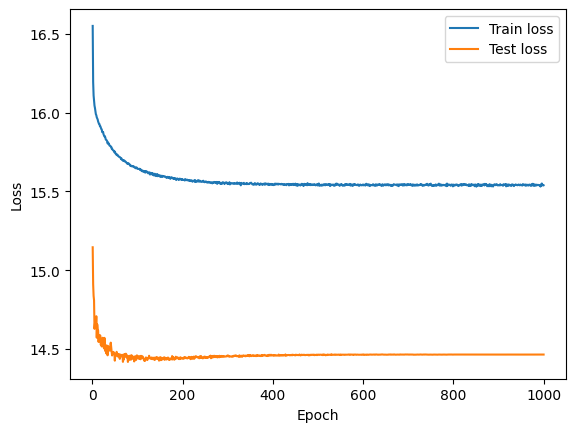

In [43]:
# Plot losses
plt.plot(range(1, EPOCHS + 1), train_loss, label="Train loss")
plt.plot(range(1, EPOCHS + 1), test_loss, label="Test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

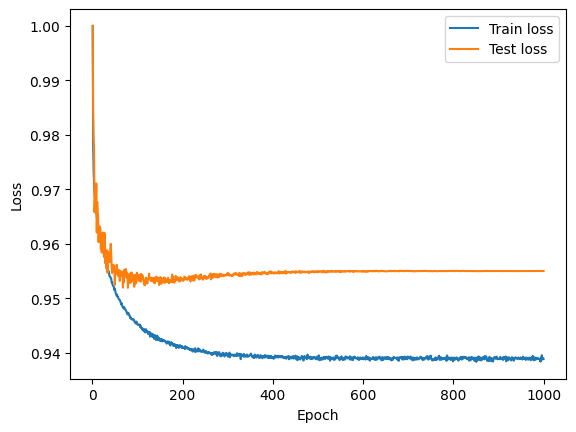

In [44]:
# Plot normalized losses
plt.plot(range(1, EPOCHS + 1), np.array(train_loss) / np.max(train_loss), label="Train loss")
plt.plot(range(1, EPOCHS + 1), np.array(test_loss) / np.max(test_loss), label="Test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [45]:
# New model
if model_name is None:
    model_name = f"{datetime.now().strftime('%y%m%d%H%M%S')}_model_{model.__class__.__name__}_E{EPOCHS}_B{BATCH_SIZE}_LR{LR}_GAMMA{GAMMA}_TRAIN{train_loss[-1]:.4f}_TEST{test_loss[-1]:.4f}.pth"

In [46]:
# Save the model
if not os.path.exists(save_path):
    os.makedirs(save_path)
torch.save(model.state_dict(), save_path + model_name + ".pth")
print(f"Model saved as {model_name}")

# Save the losses
np.save(save_path + model_name + "_loss.npy", np.array([train_loss, test_loss]))

Model saved as relu


## Evaluation

In [47]:
# Load the model
model = model_type().to(DEVICE)
model.load_state_dict(torch.load(save_path + model_name + ".pth", weights_only=True, map_location=DEVICE))

<All keys matched successfully>

In [48]:
# Evaluation Metrics
model.eval()

# Eval Size
eval_size = 1000

true_labels = break_out_solution(test_dataset.tensors[1][:eval_size])
pred_labels = break_out_solution(model(test_dataset.tensors[0][:eval_size]))

# Calculate evaluation metrics
for i in range(len(true_labels)):
    print(f"Class {i + 1}:")
    print(f"Accuracy: {accuracy_score(true_labels[i], pred_labels[i])}")
    print(f"Precision: {precision_score(true_labels[i], pred_labels[i], average='macro')}")
    print(f"Recall: {recall_score(true_labels[i], pred_labels[i], average='macro')}")
    print(f"F1 Score: {f1_score(true_labels[i], pred_labels[i], average='macro')}")
    print()

Class 1:
Accuracy: 0.809
Precision: 0.5360366428667654
Recall: 0.5373821668432623
F1 Score: 0.5366843134605594

Class 2:
Accuracy: 0.984
Precision: 0.5
Recall: 0.492
F1 Score: 0.4959677419354839

Class 3:
Accuracy: 0.822
Precision: 0.7026956747854728
Recall: 0.685345169216137
F1 Score: 0.6931542365401588

Class 4:
Accuracy: 0.888
Precision: 0.6595108695652174
Recall: 0.63785167441642
F1 Score: 0.6474927924865607

Class 5:
Accuracy: 0.596
Precision: 0.479456717971971
Recall: 0.45930160825845656
F1 Score: 0.4598325287203048

Class 6:
Accuracy: 0.972
Precision: 0.8142857142857143
Recall: 0.6875532821824382
F1 Score: 0.7335464961364242

Class 7:
Accuracy: 0.866
Precision: 0.8044411929648033
Recall: 0.7713542015435316
F1 Score: 0.7849469492626088

Class 8:
Accuracy: 0.457
Precision: 0.3861851182629867
Recall: 0.3479063680217131
F1 Score: 0.3401502429313027

Class 9:
Accuracy: 0.532
Precision: 0.5502683646478314
Recall: 0.5937423549127814
F1 Score: 0.4868646022121165

Class 10:
Accuracy: 0.6

c:\Users\ethan\school\MSAAI\AAI 521\final_project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ethan\school\MSAAI\AAI 521\final_project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ethan\school\MSAAI\AAI 521\final_project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

Class 1:


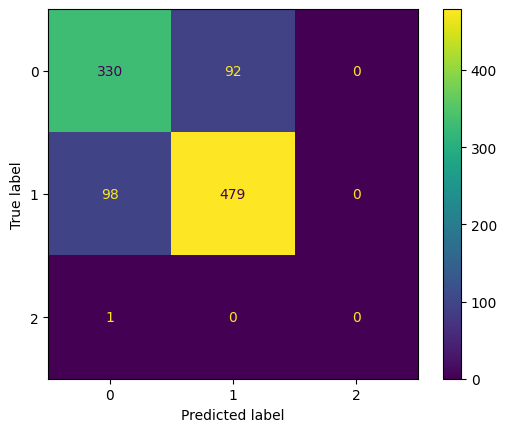


Class 2:


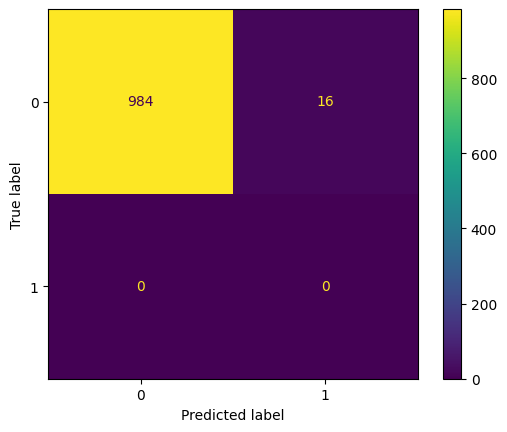


Class 3:


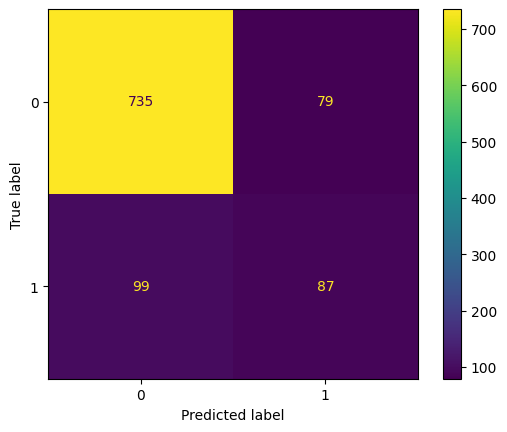


Class 4:


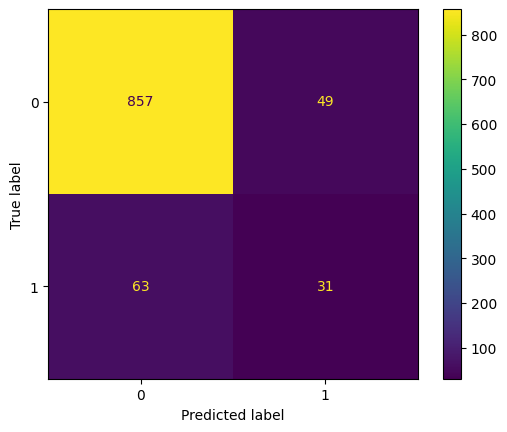


Class 5:


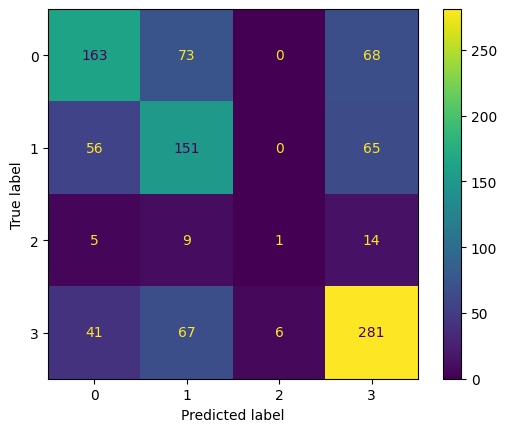


Class 6:


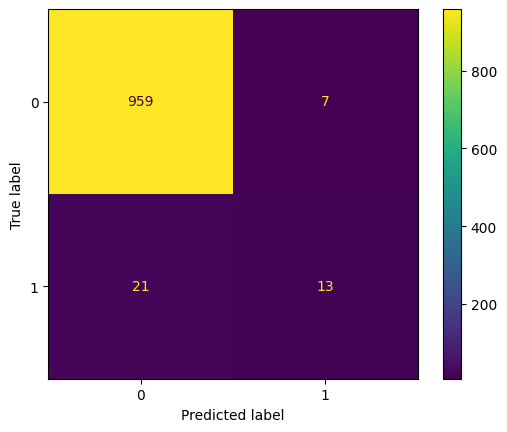


Class 7:


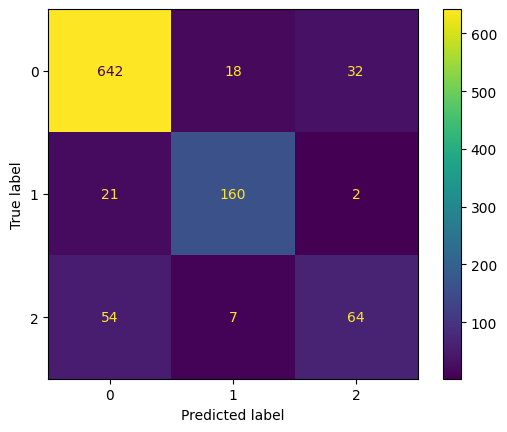


Class 8:


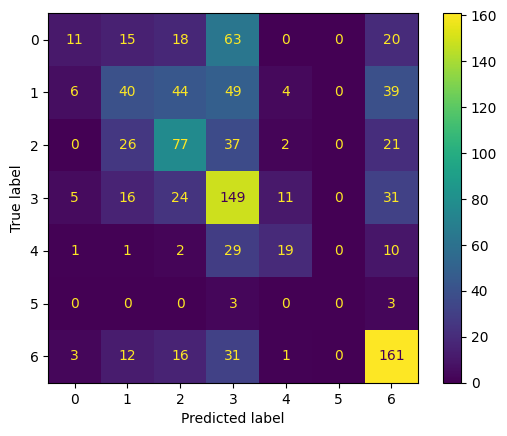


Class 9:


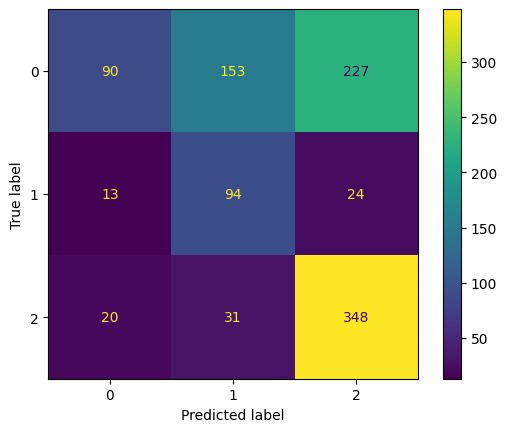


Class 10:


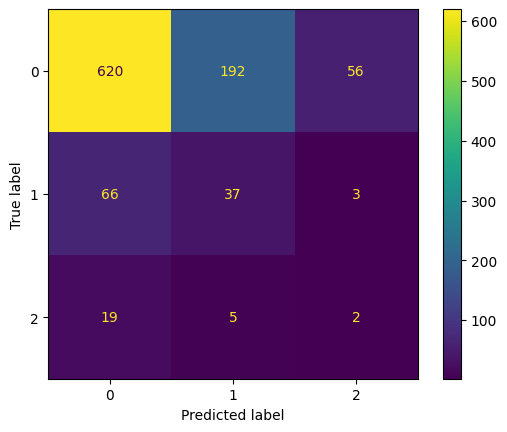


Class 11:


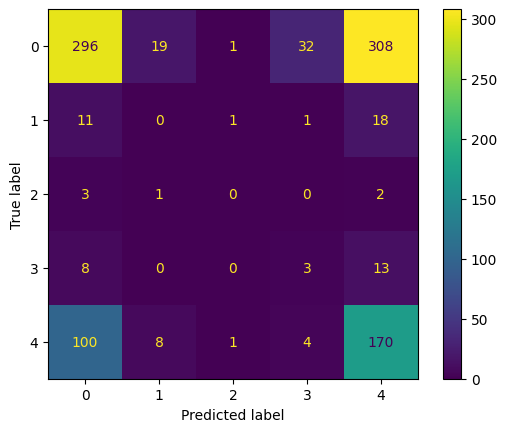

In [49]:
# Display confusion matrices in pretty format
for i in range(len(true_labels)):
    print(f"Class {i + 1}:")
    cm = confusion_matrix(true_labels[i], pred_labels[i])
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()
    plt.show()
    print()
